# Aprendizado Profundo em Grafos: Implementações com PyTorch Geometric

Este notebook explora três tarefas fundamentais em Grafos e Redes Neurais para Grafos (GNNs) utilizando a biblioteca PyTorch Geometric (PyG):

1.  **Classificação de Nós (Node Classification):** Prever o rótulo (categoria) de cada nó em um grafo.
2.  **Previsão de Arestas (Link Prediction):** Determinar a probabilidade de existência de uma aresta entre dois nós.
3.  **Detecção de Anomalias (Anomaly Detection):** Identificar nós que se comportam de maneira anômala em relação à sua vizinhança.

Iniciamos instalando as bibliotecas necessárias. O PyTorch Geometric requer algumas dependências específicas (`torch-scatter`, `torch-sparse`, etc.) para lidar com as operações de grafos de forma eficiente.

In [2]:
!pip install torch-scatter
!pip install torch-sparse
!pip install torch-geometric
!pip install torch-cluster
!pip install pygod
!pip install networkx
!pip install --upgrade scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-scatter: filename=torch_scatter-2.1.2-cp312-cp312-linux_x86_64.whl size=3807841 sha256=87fd1e0ba88290c323809f0198b0fadcf28e8c5848d983117b7e0d677a21c743
  Stored in directory: /root/.cache/pip/wheels/84/20/50/44800723f57cd798630e77b3ec83bc80bd26a1e3dc3a672ef5
Successfully built torch-scatter
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-sparse: filename=torch_sparse-0.6.18-cp312-cp312-linux_x86_64.whl size=2906583 sha256=6ca669a7fc5a6677936c1c05a65f9bc95e73f3e37610de990cd53fc2fe20d820
  Stored in directory: /root/.cache/pip/wheels/71/fa/21/bd1d78ce1629aec4ecc924a63b82f6949dda484b6321eac6f2
Successfully built torch-sparse
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
from torch_geometric.utils import to_networkx
import torch_geometric.transforms as T
import torch
import matplotlib.pyplot as plt
import networkx as nx
import random
import numpy as np
from collections import Counter

In [4]:
#Setando determinismo para reprodução do resultado

random_seed = 123
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)

## 2. Tarefa: Classificação de Nós

Nesta tarefa, o objetivo é prever a categoria de cada nó no grafo.

### Carregando o Dataset Cora

Vamos utilizar o **Cora**, um dos datasets mais clássicos para classificação de nós. Ele consiste em uma rede de citações de artigos científicos.

-   **Nós:** Artigos científicos.
-   **Arestas:** Citações (se o artigo A cita o artigo B, existe uma aresta entre eles).
-   **Features dos Nós:** Um vetor *bag-of-words* representando o conteúdo de cada artigo.
-   **Rótulos (Classes):** A área de pesquisa de cada artigo (7 classes no total).

O PyTorch Geometric facilita o carregamento de datasets populares como este.

# Carregando dataset

In [5]:
from torch_geometric.datasets import Planetoid
dataset = Planetoid(root='/tmp/Cora', name='Cora')
print(f"Número de Grafos: {len(dataset)}")
print(f"Número de classes de nós: {dataset.num_classes}")
print(f"Número de features: {dataset.num_node_features}")

Número de Grafos: 1
Número de classes de nós: 7
Número de features: 1433


Processing...
Done!


In [6]:
graph = dataset[0]

print(f"Número de nós: {graph.num_nodes}")
print(f"Número de arestas: {graph.num_edges}")
print(f"Número de features: {graph.num_node_features}")

Número de nós: 2708
Número de arestas: 10556
Número de features: 1433


In [7]:
graph.x

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [8]:
graph.edge_index.T

tensor([[ 633,    0],
        [1862,    0],
        [2582,    0],
        ...,
        [ 598, 2707],
        [1473, 2707],
        [2706, 2707]])

In [9]:
print("Distribuicoes de Classes")
sorted(Counter(graph.y.tolist()).items())

Distribuicoes de Classes


[(0, 351), (1, 217), (2, 418), (3, 818), (4, 426), (5, 298), (6, 180)]

### Visualização do Grafo

Para entender melhor a estrutura da rede, vamos visualizar um subgrafo com 1000 nós. Criamos funções auxiliares para converter o objeto `Data` do PyG para um formato compatível com `networkx` e depois plotá-lo. Cada cor no gráfico representa uma das 7 classes de artigos.

In [10]:
def convert_to_networkx(graph, n_sample = None):
  g = to_networkx(graph, node_attrs=["x"])
  y = graph.y.cpu().numpy()

  if n_sample is not None:
    sampled_nodes = random.sample(sorted(g.nodes), n_sample)
    g = g.subgraph(sampled_nodes)
    y = y[sampled_nodes] # Corrected line: use array indexing instead of calling the array
  return g, y

def plot_graph(g, y):
  plt.figure(figsize=(10, 10))
  nx.draw_spring(g, node_size = 30, arrows = False, node_color = y)
  plt.show()

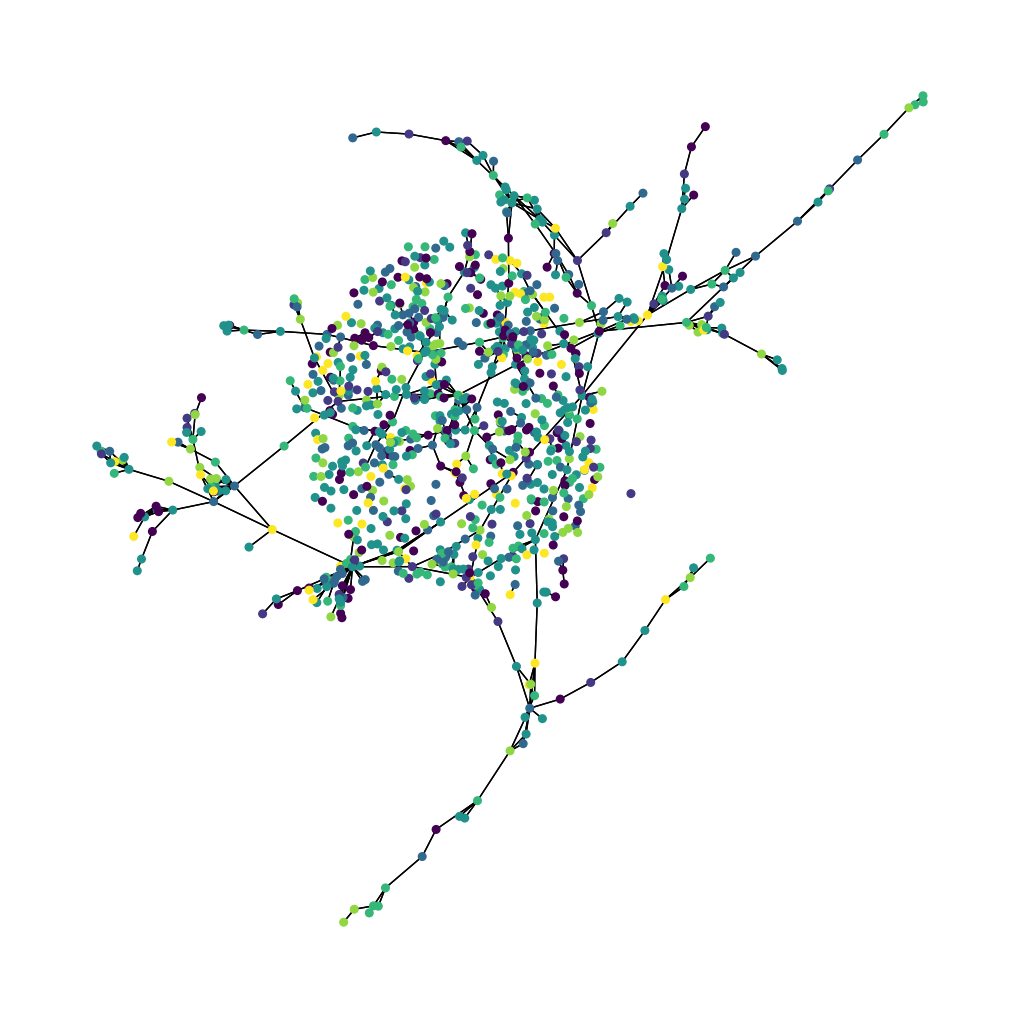

In [11]:
g, y = convert_to_networkx(graph, n_sample = 1000)
plot_graph(g, y)

- No gráfico, podemos observar a formação de *clusters* de nós com a mesma cor, indicando que artigos da mesma área de pesquisa tendem a citar uns aos outros. É essa estrutura que uma GNN irá explorar para realizar a classificação.

#Classificação de Nós

### Divisão dos Dados para Treino, Validação e Teste

Para tarefas de classificação de nós, a divisão dos dados é feita em nível de nó. O PyG cria máscaras booleanas (`train_mask`, `val_mask`, `test_mask`) que indicam quais nós pertencem a cada conjunto.

-   **Treino:** Nós usados para treinar o modelo.
-   **Validação:** Nós usados para ajustar hiperparâmetros e monitorar o *overfitting* durante o treinamento.
-   **Teste:** Nós mantidos "escondidos" para avaliar o desempenho final do modelo.

In [12]:
split = T.RandomNodeSplit(num_val = 0.1, num_test = 0.2)
graph = split(graph)
print(
    f"Número de treino: {graph.train_mask.sum()}",
    f"Número de validação: {graph.val_mask.sum()}",
    f"Número de teste: {graph.test_mask.sum()}"
)

Número de treino: 1895 Número de validação: 271 Número de teste: 542


- Com isso, conseguiremos iniciar o treinamento de um modelo de classificação de nós. Esse modelo ignora as conexões entre os nós e tenta classificar somente os rótulos dos nós usando words vectors

### Modelo Baseline: Multi-Layer Perceptron (MLP)

Antes de construir nossa GNN, criamos um modelo de referência simples: uma Rede Neural MLP. Este modelo tentará classificar os nós usando apenas suas próprias features (`graph.x`), **ignorando completamente a estrutura de conexões do grafo** (`graph.edge_index`).

Isso nos dará uma base de comparação para avaliar o quanto a informação da estrutura do grafo, utilizada pela GCN, melhora o resultado da classificação.

In [13]:
import torch.nn as nn

class MLP(nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(dataset.num_node_features, 64),
        nn.ReLU(),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Linear(32, dataset.num_classes)
    )

  def forward(self, data):
    x = data.x
    output = self.layers(x)
    return output

### Funções de Treinamento e Avaliação

Para organizar o código, criamos duas funções:

1.  `train_node_classifier`: Executa o loop de treinamento. A cada época, ele realiza a passagem para frente (*forward pass*), calcula o erro (*loss*), executa a retropropagação (*backpropagation*) e atualiza os pesos do modelo.
2.  `eval_node_classifier`: Calcula a acurácia do modelo em um determinado conjunto de dados (definido por uma máscara).

In [48]:
def train_node_classifier(model, graph, optimizer, criterion, n_epochs = 200):

  train_losses = []
  val_accs = []

  for epoch in range(1, n_epochs + 1):
    model.train()
    optimizer.zero_grad()
    out = model(graph)
    loss = criterion(out[graph.train_mask], graph.y[graph.train_mask])
    loss.backward()
    optimizer.step()

    pred = out.argmax(dim = 1)
    acc = eval_node_classifier(model, graph, graph.val_mask)

    train_losses.append(loss.item())
    val_accs.append(acc)

    if epoch % 10 == 0:
      print(f"Epoch: {epoch:03d}, Train Loss: {loss:.3f}, Val Acc: {acc:.3f}")
  return model

def eval_node_classifier(model, graph, mask):
  model.eval()
  pred = model(graph).argmax(dim = 1)
  correct = (pred[mask] == graph.y[mask]).sum()
  acc = int(correct) / int(mask.sum())
  return acc

- No processo de treinamento, estabelecemos uma função dedicada para monitorar épocas, erros de treina

In [50]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
graph = graph.to(device)
graph.y = graph.y.to(torch.long) # Convert labels to long type
mlp = MLP().to(device)
optimizer_mlp = torch.optim.Adam(mlp.parameters(), lr = 0.01, weight_decay = 5e-4)
criterion = nn.CrossEntropyLoss()

mlp = train_node_classifier(mlp, graph, optimizer_mlp, criterion, n_epochs = 150)

Epoch: 010, Train Loss: 0.313, Val Acc: 0.878
Epoch: 020, Train Loss: 0.040, Val Acc: 0.882
Epoch: 030, Train Loss: 0.001, Val Acc: 0.876
Epoch: 040, Train Loss: 0.000, Val Acc: 0.852
Epoch: 050, Train Loss: 0.000, Val Acc: 0.862
Epoch: 060, Train Loss: 0.000, Val Acc: 0.866
Epoch: 070, Train Loss: 0.000, Val Acc: 0.872
Epoch: 080, Train Loss: 0.001, Val Acc: 0.880
Epoch: 090, Train Loss: 0.001, Val Acc: 0.888
Epoch: 100, Train Loss: 0.001, Val Acc: 0.892
Epoch: 110, Train Loss: 0.001, Val Acc: 0.890
Epoch: 120, Train Loss: 0.001, Val Acc: 0.888
Epoch: 130, Train Loss: 0.001, Val Acc: 0.882
Epoch: 140, Train Loss: 0.001, Val Acc: 0.888
Epoch: 150, Train Loss: 0.001, Val Acc: 0.888


Agora, configuramos e treinamos nosso modelo MLP.

-   **Optimizer:** Usamos o otimizador Adam, comum para treinar redes neurais.
-   **Criterion (Loss Function):** `CrossEntropyLoss` é a função de perda padrão para tarefas de classificação multiclasse.

In [51]:
test_acc = eval_node_classifier(mlp, graph, graph.test_mask)
print(f"Test Accuracy: {test_acc:.3f}")

Test Accuracy: 0.880


- O resultado mostra que o MLP teve um desempenho um pouco menor que o GCN, mostrando a eficiência do modelo focado em analisar uma estrutura de dados em grafos

# GCN
### Modelo Principal: Graph Convolutional Network (GCN)

Agora, construímos o modelo de GNN. A GCN é um tipo de rede neural convolucional que opera diretamente em grafos. A principal diferença em relação ao MLP é que ela utiliza a estrutura de conectividade para aprender as representações dos nós.

A "convolução" em um grafo funciona através de um processo de **agregação de mensagens**. Cada nó coleta as features de seus vizinhos, as transforma e as combina com suas próprias features para gerar uma nova representação (embedding).

Nosso modelo GCN terá duas camadas convolucionais (`GCNConv`).

In [52]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class GCN(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = GCNConv(dataset.num_node_features, 16)
    self.conv2 = GCNConv(16, dataset.num_classes)

  def forward(self, data):
    #primeira mensagem
    x, edge_index = data.x, data.edge_index
    x = self.conv1(x, edge_index)
    x = F.relu(x)
    #segunda mesangem
    output = self.conv2(x, edge_index)
    return output

In [53]:
gcn = GCN().to(device)
optimizer_gcn = torch.optim.Adam(gcn.parameters(), lr = 0.01, weight_decay = 5e-4)
criterion = nn.CrossEntropyLoss()

gcn = train_node_classifier(gcn, graph, optimizer_gcn, criterion, n_epochs = 150)

Epoch: 010, Train Loss: 0.510, Val Acc: 0.878
Epoch: 020, Train Loss: 0.220, Val Acc: 0.918
Epoch: 030, Train Loss: 0.118, Val Acc: 0.924
Epoch: 040, Train Loss: 0.052, Val Acc: 0.930
Epoch: 050, Train Loss: 0.027, Val Acc: 0.926
Epoch: 060, Train Loss: 0.017, Val Acc: 0.924
Epoch: 070, Train Loss: 0.013, Val Acc: 0.920
Epoch: 080, Train Loss: 0.012, Val Acc: 0.924
Epoch: 090, Train Loss: 0.011, Val Acc: 0.924
Epoch: 100, Train Loss: 0.010, Val Acc: 0.924
Epoch: 110, Train Loss: 0.010, Val Acc: 0.924
Epoch: 120, Train Loss: 0.009, Val Acc: 0.924
Epoch: 130, Train Loss: 0.009, Val Acc: 0.924
Epoch: 140, Train Loss: 0.008, Val Acc: 0.918
Epoch: 150, Train Loss: 0.008, Val Acc: 0.918


In [54]:
test_acc = eval_node_classifier(gcn, graph, graph.test_mask)
print(f"Test Accuracy: {test_acc:.3f}")

Test Accuracy: 0.926


### Comparação de Resultados

A GCN alcança uma acurácia significativamente maior que a do MLP. Isso demonstra o poder de utilizar a estrutura de conectividade do grafo. Ao agregar informações dos vizinhos, a GCN aprende representações de nós muito mais ricas e contextuais, o que leva a uma classificação mais precisa.

# Visualização das Predições

Para visualizar o desempenho do modelo, plotamos o subgrafo de teste.

-   **Nós Amarelos:** Classificações corretas.
-   **Nós Roxos:** Classificações incorretas.

Podemos ver que a grande maioria dos nós no conjunto de teste foi classificada corretamente.

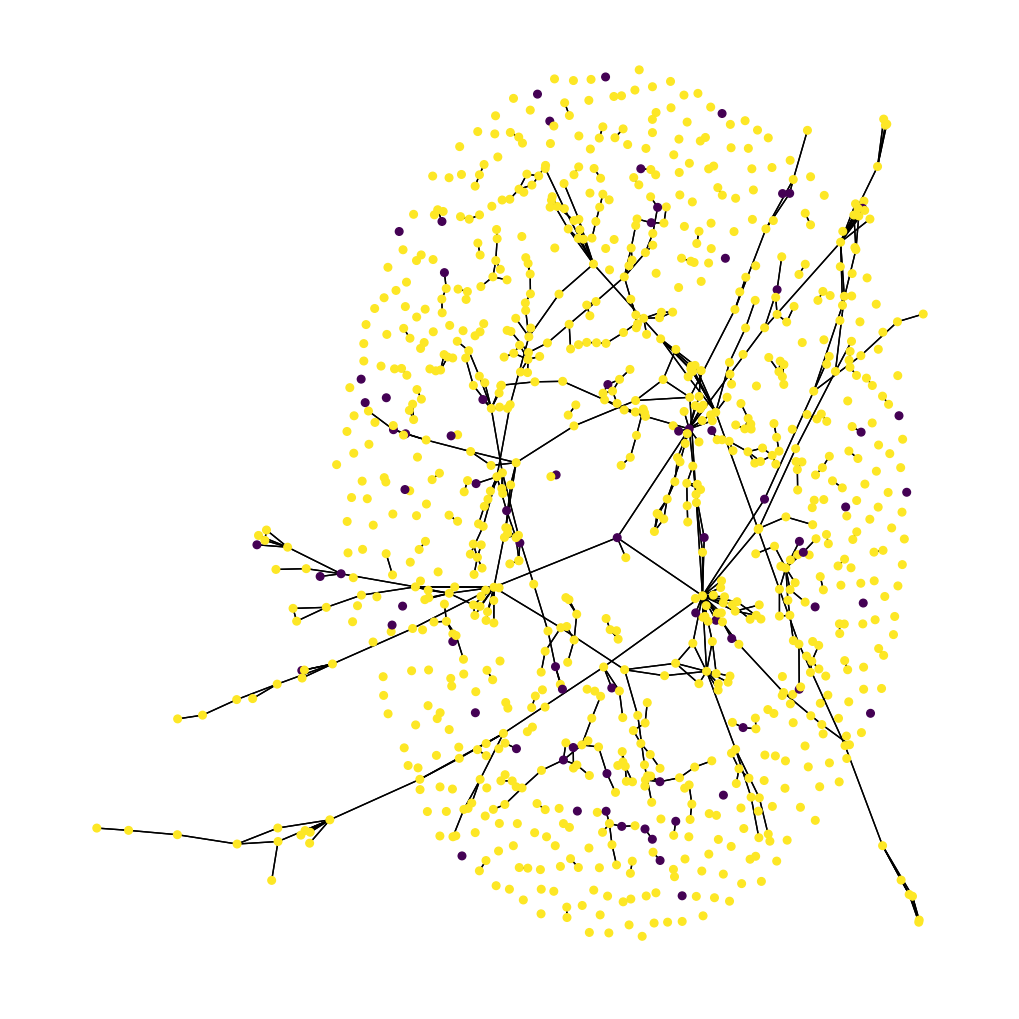

In [55]:
gcn.eval()
pred = gcn(graph).argmax(dim = 1)
corrects = (pred[graph.test_mask] == graph.y[graph.test_mask]).cpu().numpy().astype(int)
test_index = np.arange(len(graph.x)) [graph.test_mask.cpu().numpy()]
g, y = convert_to_networkx(graph)
g_test = g.subgraph(test_index)
plot_graph(g_test, corrects)

#3. Tarefa: Previsão de Arestas (Link Prediction)

Nesta tarefa, o objetivo é prever se uma aresta existe entre dois nós. Isso é útil para, por exemplo, recomendar amigos em uma rede social ou prever interações entre proteínas.

O processo envolve:
1.  **Remover** uma parte das arestas do grafo para usar como dados de validação e teste.
2.  Treinar um modelo para distinguir entre **arestas existentes (positivas)** e **arestas não existentes (negativas)**.
3.  Avaliar a capacidade do modelo de prever corretamente as arestas que foram removidas.

### Modelo Encoder-Decoder para Link Prediction

Usamos uma arquitetura do tipo *encoder-decoder*:

1.  **Encoder:** Uma GNN (como a GCN) que aprende *embeddings* de baixa dimensão para cada nó, capturando sua posição e vizinhança na rede.
2.  **Decoder:** Um mecanismo que, a partir dos *embeddings* de dois nós, calcula uma pontuação indicando a probabilidade de haver uma aresta entre eles. Um decoder comum é simplesmente o **produto escalar** (*dot product*) entre os vetores de embedding dos dois nós.

In [56]:
class Net(torch.nn.Module):
  def __init__(self, in_channels, hidden_channels, out_channels):
    super().__init__()
    self.conv1 = GCNConv(in_channels, hidden_channels)
    self.conv2 = GCNConv(hidden_channels, out_channels)

  def encode(self, x, edge_index):
    x = self.conv1(x, edge_index).relu()
    return self.conv2(x, edge_index)

  def decode(self, z, edge_label_index):
    return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

  def decode_all(self, z):
    prob_adj = z @ z.t()
    return (prob_adj > 0).nonzero(as_tuple=False).t()

In [57]:
from sklearn.metrics import roc_auc_score
from torch_geometric.utils import negative_sampling

def train_link_predictor(model, train_data, optimizer, criterion, n_epochs = 100):
  for epoch in range(1, n_epochs + 1):
    model.train()
    optimizer.zero_grad()
    z = model.encode(train_data.x, train_data.edge_index)

    #amostragem de negativos de treinamento para cada época de treinamento
    neg_edge_index = negative_sampling(
        edge_index = train_data.edge_index, num_nodes = train_data.num_nodes,
        num_neg_samples = train_data.edge_label_index.size(1), method = 'sparse')

    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index],
        dim = - 1,
    )
    edge_label = torch.cat([
        train_data.edge_label,
        train_data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim = 0)

    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()

    val_auc = eval_link_predictor(model, val_data)

    if epoch %10 == 0:
      print(f"Epoch: {epoch:03d}, Train Loss: {loss:.3f}, Val AUC: {val_auc:.3f}")
    # The function should return the model after the loop finishes, not inside the loop
  return model

@torch.no_grad()
def eval_link_predictor(model, data):
  model.eval()
  z = model.encode(data.x, data.edge_index)
  out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
  return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())

In [58]:
""" deleting node split masks """

del graph.train_mask
del graph.val_mask
del graph.test_mask

### Divisão dos Dados e Treinamento

Usamos a transformação `RandomLinkSplit` para dividir as **arestas** (e não os nós) em conjuntos de treino, validação e teste. Esta função também gera automaticamente amostras de **arestas negativas** (arestas que não existem no grafo) para o treinamento.

A métrica de avaliação para esta tarefa será a **AUC (Area Under the ROC Curve)**, que mede a capacidade do modelo de ranquear corretamente as amostras positivas acima das negativas.

In [59]:
split = T.RandomLinkSplit(
    num_val = 0.05,
    num_test = 0.1,
    is_undirected = True,
    add_negative_train_samples = False,
    neg_sampling_ratio = 1.0,
)
train_data, val_data, test_data = split(graph)
print('train_data:', train_data)
print('val_data:', val_data)
print('test_data:', test_data)

train_data: Data(x=[2708, 1433], edge_index=[2, 8976], y=[2708], s=[2708, 2708], edge_label=[4488], edge_label_index=[2, 4488])
val_data: Data(x=[2708, 1433], edge_index=[2, 8976], y=[2708], s=[2708, 2708], edge_label=[526], edge_label_index=[2, 526])
test_data: Data(x=[2708, 1433], edge_index=[2, 9502], y=[2708], s=[2708, 2708], edge_label=[1054], edge_label_index=[2, 1054])


In [60]:
model = Net(dataset.num_features, 128, 64).to(device)
optimizer = torch.optim.Adam(params = model.parameters(), lr = 0.01)
criterion = torch.nn.BCEWithLogitsLoss()

model = train_link_predictor(model, train_data, optimizer, criterion)

Epoch: 010, Train Loss: 0.665, Val AUC: 0.698
Epoch: 020, Train Loss: 0.598, Val AUC: 0.828
Epoch: 030, Train Loss: 0.490, Val AUC: 0.867
Epoch: 040, Train Loss: 0.461, Val AUC: 0.889
Epoch: 050, Train Loss: 0.440, Val AUC: 0.905
Epoch: 060, Train Loss: 0.432, Val AUC: 0.918
Epoch: 070, Train Loss: 0.425, Val AUC: 0.922
Epoch: 080, Train Loss: 0.420, Val AUC: 0.923
Epoch: 090, Train Loss: 0.418, Val AUC: 0.923
Epoch: 100, Train Loss: 0.415, Val AUC: 0.920


In [61]:
test_auc = eval_link_predictor(model, test_data)
print(f"Test: {test_auc:.3f}")

Test: 0.905


# Detecção de Anomalia
## 4. Tarefa: Detecção de Anomalias (Outlier Detection)

O objetivo aqui é identificar nós que são estruturalmente diferentes de sua vizinhança. Uma anomalia em um grafo pode ser um nó com um padrão de conexão incomum ou com features muito distintas de seus vizinhos.

### Modelo DOMINANT

Utilizaremos o `DOMINANT`, um modelo de GNN projetado especificamente para detecção de anomalias. Ele funciona reconstruindo as features e a estrutura de adjacência de cada nó e, em seguida, calculando um "score de anomalia" com base no erro de reconstrução. Nós com alto erro de reconstrução são considerados anômalos.

In [63]:
from pygod.utils import load_data

graph = dataset[0]

from pygod.detector import DOMINANT
from sklearn.metrics import roc_auc_score, average_precision_score

graph.y = graph.y.bool()
model = DOMINANT()
model = model.fit(graph)
outliers_scores = model.decision_function(graph)
auc = roc_auc_score(graph.y.cpu().numpy(), outliers_scores)
ap = average_precision_score(graph.y.cpu().numpy(), outliers_scores)
print(f"-----AUC: {auc:.3f}, AP: {ap:.3f}-----")

/usr/local/lib/python3.12/dist-packages/torch_geometric/sampler/neighbor_sampler.py:61: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn(f"Using '{self.__class__.__name__}' without a "


-----AUC: 0.471, AP: 0.858-----


### Análise dos Resultados de Detecção de Anomalia


* **AUC (Area Under the ROC Curve): 0.471**
    * A AUC mede a capacidade do modelo de distinguir entre as classes. Um valor de 0.5 representa um desempenho aleatório (como jogar uma moeda), e 1.0 é um desempenho perfeito.
    * Um valor de **0.471** está ligeiramente **pior que o aleatório**. Isso indica que o modelo `DOMINANT` não conseguiu encontrar um padrão estrutural claro para separar os nós da classe `0` das outras classes. Essencialmente, ser de uma área de pesquisa diferente (classe 1-6) não significa, para o modelo, ser uma "anomalia estrutural". Isso é esperado, pois os clusters de diferentes áreas (como vimos no gráfico) são estruturalmente semelhantes, apenas conectados a diferentes grupos de nós.

* **AP (Average Precision): 0.858**
    * A *Average Precision* (ou Precisão Média) resume a curva de precisão-revocação e é uma métrica mais informativa que a AUC em cenários com grande desbalanceamento de classes.
    * Um valor de **0.858** é relativamente alto. Ele indica que, entre os nós que o modelo classificou como anômalos com maior confiança, a maioria deles **realmente pertencia às classes de 1 a 6** (que definimos como "anomalias"). Ou seja, o modelo foi bom em ranquear corretamente as anomalias que ele encontrou, mesmo que sua capacidade geral de separação (AUC) tenha sido fraca.

**Conclusão:** O resultado mostra que o conceito de "anomalia" para o modelo `DOMINANT` (baseado na estrutura e features) não corresponde diretamente à separação de classes do dataset `Cora`. O modelo não aprendeu a separar a classe 0 das demais, mas foi razoavelmente preciso ao ranquear os nós que ele considerou mais anômalos.